In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import config as cfg

## Load train data

In [2]:
sales = pd.read_csv(cfg.FILENAMES['TRAIN_SALES'])
print(len(sales))
sales.head(2)

2935849


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [3]:
items = pd.read_csv(cfg.FILENAMES["ITEMS"])
train = pd.merge(sales, items, how="left", on="item_id")
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37
1,03.01.2013,0,25,2552,899.0,1.0,DEEP PURPLE The House Of Blue Light LP,58


In [4]:
categories = pd.read_csv(cfg.FILENAMES["ITEM_CATEGORIES"])
train = pd.merge(train, categories, how="left", on="item_category_id")
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.0,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил


In [5]:
shops = pd.read_csv(cfg.FILENAMES["SHOPS"])
train = pd.merge(train, shops, how="left", on="shop_id")
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.0,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""


Keep only relevant columns

In [6]:
train = train[["date_block_num","shop_id","item_id","item_price","item_cnt_day","item_category_id"]]
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,59,22154,999.00,1.0,37
1,0,25,2552,899.00,1.0,58
2,0,25,2552,899.00,-1.0,58
3,0,25,2554,1709.05,1.0,58
4,0,25,2555,1099.00,1.0,56


#### Remove shops and items not in predict_set

In [8]:
to_pred = pd.read_csv(cfg.FILENAMES['TEST_SALES'])
to_pred.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [9]:
to_pred_items = set(to_pred["item_id"])
to_pred_shops = set(to_pred["shop_id"])
train_filtered = train.loc[(train["item_id"].isin(to_pred_items)) & (train["shop_id"].isin(to_pred_shops))]
print(f"From {len(train)} to {len(train_filtered)}")

From 2935849 to 1224439


#### Remove not positive days

In [12]:
train_filtered = train_filtered.loc[(train_filtered["item_cnt_day"]>0)]

## Aggregate by month

In [13]:
train_monthly = (train_filtered.groupby(["date_block_num","shop_id","item_id","item_category_id"])
                .agg({"item_price":["mean","sum"], "item_cnt_day":["sum","mean","count"]})
                .reset_index())
train_monthly.columns = ["date_block_num","shop_id", "item_id", "item_category_id",
                        "item_mean_price", "item_total_sold", "item_cnt_month", "item_cnt_mean", "transactions"]
print(len(train_monthly))
train_monthly.head(2)

599912


,date_block_num,shop_id,item_id,item_category_id,item_mean_price,item_total_sold,item_cnt_month,item_cnt_mean,transactions
0,0,2,33,37,499.0,499.0,1.0,1.0,1
1,0,2,482,73,3300.0,3300.0,1.0,1.0,1


## Create missing combinations

### Missing combinations in train set

In [14]:
items_set = set(train_monthly["item_id"])
shops_set = set(train_monthly["shop_id"])

empty = []
for date in range(34):
    for item in items_set:
        for shop in shops_set:
            empty.append({"date_block_num":date,"item_id":item, "shop_id":shop})

empty_df = pd.DataFrame.from_dict(empty)
print(len(empty_df))
empty_df.head()

6734448


,date_block_num,item_id,shop_id
0,0,8192,2
1,0,8192,3
2,0,8192,4
3,0,8192,5
4,0,8192,6


In [20]:
sales_complete = pd.merge(empty_df, train_monthly, on=["date_block_num","item_id","shop_id"], how="left")
print(len(sales_complete))
sales_complete.head()

6734448


,date_block_num,item_id,shop_id,item_category_id,item_mean_price,item_total_sold,item_cnt_month,item_cnt_mean,transactions
0,0,8192,2,NaN,NaN,NaN,NaN,NaN,NaN
1,0,8192,3,NaN,NaN,NaN,NaN,NaN,NaN
2,0,8192,4,NaN,NaN,NaN,NaN,NaN,NaN
3,0,8192,5,NaN,NaN,NaN,NaN,NaN,NaN
4,0,8192,6,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
sales_complete.loc[(sales_complete["date_block_num"]==0) &
                  (sales_complete["shop_id"]==59) &
                  (sales_complete["item_id"]==22154),'item_mean_price'].values[0]==999

True

In [22]:
sales_complete.isnull().sum()

date_block_num            0
item_id                   0
shop_id                   0
item_category_id    6134536
item_mean_price     6134536
item_total_sold     6134536
item_cnt_month      6134536
item_cnt_mean       6134536
transactions        6134536
dtype: int64

## Fill NA values

In [29]:
itemxshop_infos = (sales_complete.groupby(["item_id","shop_id"])
                  .agg({"item_category_id":"first", "item_mean_price":"mean"})
                  .reset_index())
sales_complete.update(sales_complete.drop(["item_category_id","item_mean_price"], axis=1)
                      .merge(itemxshop_infos,"left"))


In [30]:
sales_complete.isnull().sum()

date_block_num            0
item_id                   0
shop_id                   0
item_category_id    2946712
item_mean_price     2946712
item_total_sold     6134536
item_cnt_month      6134536
item_cnt_mean       6134536
transactions        6134536
dtype: int64

In [33]:
item_infos = (sales_complete.groupby(["item_id"])
                  .agg({"item_category_id":"first", "item_mean_price":"mean"})
                  .reset_index())
sales_complete.update(sales_complete.drop(["item_category_id","item_mean_price"], axis=1)
                      .merge(item_infos,"left"))

In [34]:
sales_complete.isnull().sum()

date_block_num            0
item_id                   0
shop_id                   0
item_category_id          0
item_mean_price           0
item_total_sold     6134536
item_cnt_month      6134536
item_cnt_mean       6134536
transactions        6134536
dtype: int64

In [35]:
sales_complete_fill = sales_complete.fillna(0)

In [37]:
sales_complete_fill.isnull().sum()

date_block_num      0
item_id             0
shop_id             0
item_category_id    0
item_mean_price     0
item_total_sold     0
item_cnt_month      0
item_cnt_mean       0
transactions        0
dtype: int64

In [38]:
# Extract time based features.
sales_complete_fill['year'] = sales_complete_fill['date_block_num'].apply(lambda x: ((x//12) + 2013))
sales_complete_fill['month'] = sales_complete_fill['date_block_num'].apply(lambda x: (x % 12))

## Simple EDA

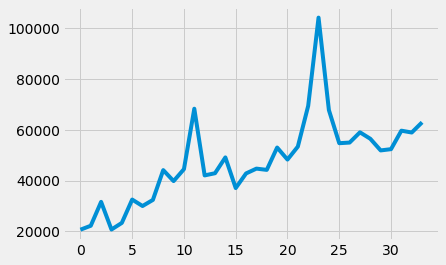

In [40]:
total_sales_monthly=sales_complete_fill.groupby("date_block_num").agg({"item_cnt_month":"sum"}).reset_index()
plt.plot(total_sales_monthly["date_block_num"], total_sales_monthly["item_cnt_month"])
plt.show()

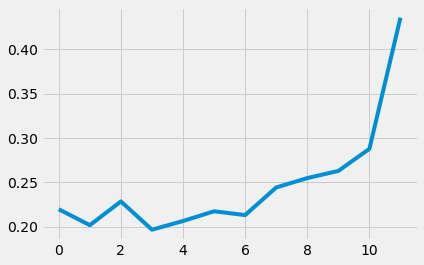

In [41]:
mean_sales_monthly = sales_complete_fill.groupby("month").agg({"item_cnt_month":"mean"}).reset_index()
plt.plot(mean_sales_monthly["month"], mean_sales_monthly["item_cnt_month"])
plt.show()

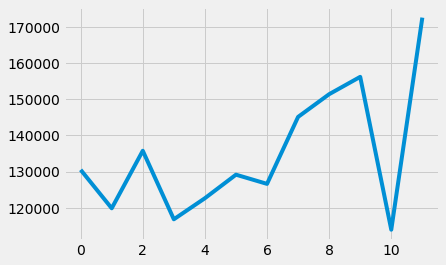

In [44]:
sum_sales_monthly = sales_complete_fill.groupby("month").agg({"item_cnt_month":"sum"}).reset_index()
plt.plot(sum_sales_monthly["month"], sum_sales_monthly["item_cnt_month"])
plt.show()

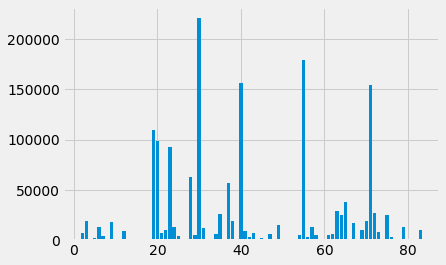

In [46]:
category_sales_mean = sales_complete_fill.groupby("item_category_id").agg({"item_cnt_month":"sum"}).reset_index()
plt.bar(category_sales_mean["item_category_id"], category_sales_mean["item_cnt_month"])
plt.show()

## EDA to remove outliers

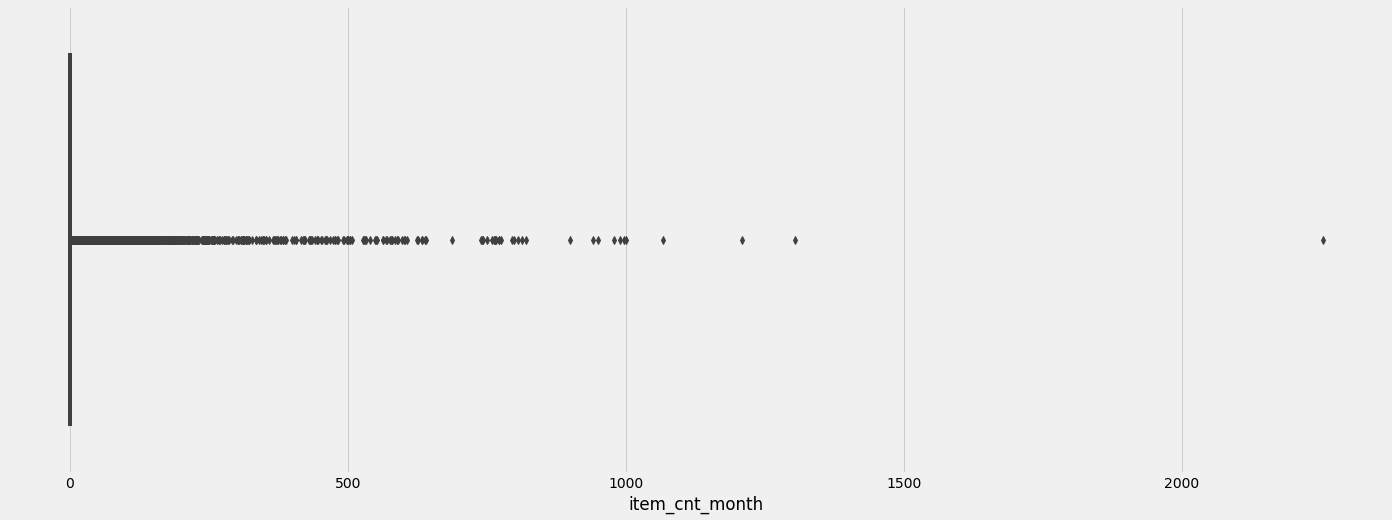

In [48]:
plt.subplots(figsize=(22, 8))
sns.boxplot(sales_complete_fill['item_cnt_month'])
plt.show()


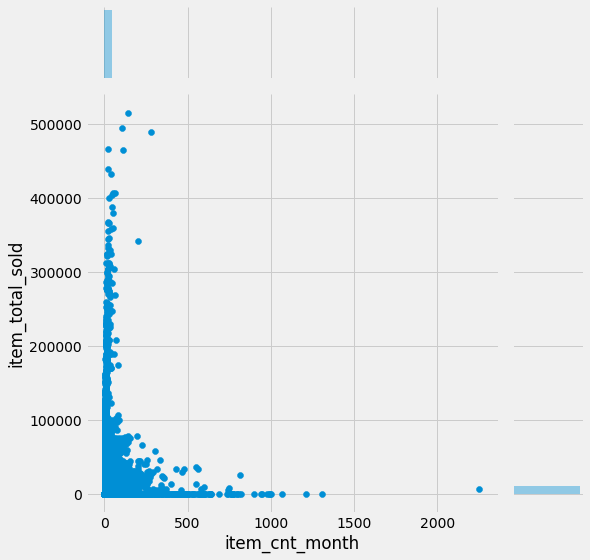

In [50]:
sns.jointplot(x="item_cnt_month", y="item_total_sold", data=sales_complete_fill, height=8)
plt.show()

Decided not to remove any outliers

## Create label

Label = next month sellings

In [62]:
sales_complete_fill['item_cnt_next_month'] = (sales_complete_fill.sort_values("date_block_num")
                                   .groupby(["item_id","shop_id"])["item_cnt_month"].shift(-1))

In [67]:
sales_complete_fill.loc[(sales_complete_fill["shop_id"]==3) & (sales_complete_fill["item_id"]==30),].head(3)

,date_block_num,item_id,shop_id,item_category_id,item_mean_price,item_total_sold,item_cnt_month,item_cnt_mean,transactions,year,month,item_cnt_next_month
421,0,30,3,40.0,274.210695,0.0,0.0,0.00,0.0,2013,0,4.0
198493,1,30,3,40.0,274.210695,1596.0,4.0,1.00,4.0,2013,1,5.0
396565,2,30,3,40.0,274.210695,1596.0,5.0,1.25,4.0,2013,2,2.0


In [72]:
print(len(sales_complete_fill.loc[sales_complete_fill["date_block_num"]==33]))
sales_complete_fill.isnull().sum()

198072


date_block_num              0
item_id                     0
shop_id                     0
item_category_id            0
item_mean_price             0
item_total_sold             0
item_cnt_month              0
item_cnt_mean               0
transactions                0
year                        0
month                       0
item_cnt_next_month    198072
dtype: int64

# Feature engineering

- no longer exists -> boolean True if product not sold for 6 months
- mean category sold over month OK
- total category sold over month OK
- mean shop sold over month OK
- total category sold over month OK
- trend? over 3/
- Time-based mean for categories/shops

#### Category based features

In [75]:
gp_cat = (sales_complete_fill.groupby(["date_block_num","item_category_id"])
          .agg({"item_cnt_month":["sum","mean"], "item_mean_price":"mean"})
         .reset_index())
gp_cat.columns = ["date_block_num", "item_category_id", "cat_total_sold", "cat_mean_sold", "cat_mean_price"]
gp_cat.head()

,date_block_num,item_category_id,cat_total_sold,cat_mean_sold,cat_mean_price
0,0,2.0,296.0,0.704762,2004.917482
1,0,3.0,0.0,0.000000,2045.854253
2,0,5.0,90.0,0.535714,599.593221
3,0,6.0,435.0,1.150794,2387.060418
4,0,7.0,0.0,0.000000,2705.906307


In [76]:
train_features = pd.merge(sales_complete_fill, gp_cat, how="left", on=["date_block_num","item_category_id"])
train_features.head(2)

,date_block_num,item_id,shop_id,item_category_id,item_mean_price,item_total_sold,item_cnt_month,item_cnt_mean,transactions,year,month,item_cnt_next_month,cat_total_sold,cat_mean_sold,cat_mean_price
0,0,8192,2,38.0,391.37405,0.0,0.0,0.0,0.0,2013,0,0.0,374.0,0.081695,743.872316
1,0,8192,3,38.0,391.37405,0.0,0.0,0.0,0.0,2013,0,0.0,374.0,0.081695,743.872316


## Shop based features

In [80]:
gp_shop = (train_features.groupby(["date_block_num","shop_id"])
          .agg({"item_cnt_month":["sum","mean"], "item_mean_price":"mean"})
         .reset_index())
gp_shop.columns = ["date_block_num", "shop_id", "shop_total_sold", "shop_mean_sold", "shop_mean_price"]
gp_shop.head()

,date_block_num,shop_id,shop_total_sold,shop_mean_sold,shop_mean_price
0,0,2,250.0,0.053011,1019.611393
1,0,3,187.0,0.039652,1019.611393
2,0,4,459.0,0.097328,1019.611393
3,0,5,0.0,0.000000,1019.611393
4,0,6,872.0,0.184902,1019.611393


In [81]:
train_features = pd.merge(train_features, gp_shop, how="left", on=["date_block_num","shop_id"])
train_features.head(2)

,date_block_num,item_id,shop_id,item_category_id,item_mean_price,item_total_sold,item_cnt_month,item_cnt_mean,transactions,year,month,item_cnt_next_month,cat_total_sold,cat_mean_sold,cat_mean_price,shop_total_sold,shop_mean_sold,shop_mean_price
0,0,8192,2,38.0,391.37405,0.0,0.0,0.0,0.0,2013,0,0.0,374.0,0.081695,743.872316,250.0,0.053011,1019.611393
1,0,8192,3,38.0,391.37405,0.0,0.0,0.0,0.0,2013,0,0.0,374.0,0.081695,743.872316,187.0,0.039652,1019.611393


## Item based features

In [85]:
gp_item = (train_features.groupby(["item_id"])
          .agg({"item_mean_price":["min","max"]})
         .reset_index())
gp_item.columns = ["item_id", "item_min_price", "item_max_price"]
gp_item.head()

,item_id,item_min_price,item_max_price
0,30,274.210695,274.210695
1,31,507.062443,507.062443
2,32,223.382717,223.382717
3,33,237.420978,237.420978
4,38,2325.513333,2325.513333


In [86]:
train_features = pd.merge(train_features, gp_item, how="left", on=["item_id"])
train_features.head(2)

,date_block_num,item_id,shop_id,item_category_id,item_mean_price,item_total_sold,item_cnt_month,item_cnt_mean,transactions,year,month,item_cnt_next_month,cat_total_sold,cat_mean_sold,cat_mean_price,shop_total_sold,shop_mean_sold,shop_mean_price,item_min_price,item_max_price
0,0,8192,2,38.0,391.37405,0.0,0.0,0.0,0.0,2013,0,0.0,374.0,0.081695,743.872316,250.0,0.053011,1019.611393,391.37405,391.37405
1,0,8192,3,38.0,391.37405,0.0,0.0,0.0,0.0,2013,0,0.0,374.0,0.081695,743.872316,187.0,0.039652,1019.611393,391.37405,391.37405


In [87]:
train_features["item_price_increase"] = train_features["item_mean_price"] - train_features["item_min_price"]
train_features["item_price_decrease"] = train_features["item_mean_price"] - train_features["item_max_price"]
train_features.head(2)

,date_block_num,item_id,shop_id,item_category_id,item_mean_price,item_total_sold,item_cnt_month,item_cnt_mean,transactions,year,...,cat_total_sold,cat_mean_sold,cat_mean_price,shop_total_sold,shop_mean_sold,shop_mean_price,item_min_price,item_max_price,item_price_increase,item_price_decrease
0,0,8192,2,38.0,391.37405,0.0,0.0,0.0,0.0,2013,...,374.0,0.081695,743.872316,250.0,0.053011,1019.611393,391.37405,391.37405,0.0,0.0
1,0,8192,3,38.0,391.37405,0.0,0.0,0.0,0.0,2013,...,374.0,0.081695,743.872316,187.0,0.039652,1019.611393,391.37405,391.37405,0.0,0.0


### Add lag values

In [93]:
lags = [1,2,3]
train_features_lagged= train_features.copy()
for col in ["item_cnt_month","cat_total_sold", "shop_total_sold"]:
    for lag in lags:
        ft_name=col+'_lag'+str(lag)
        train_features_lagged[ft_name] = (train_features_lagged.sort_values("date_block_num")
                                                               .groupby(["item_id","shop_id"])["item_cnt_month"]
                                                               .shift(lag))
train_features_lagged.loc[train_features_lagged["date_block_num"]>=3].isnull().sum()

date_block_num               0
item_id                      0
shop_id                      0
item_category_id             0
item_mean_price              0
item_total_sold              0
item_cnt_month               0
item_cnt_mean                0
transactions                 0
year                         0
month                        0
item_cnt_next_month     198072
cat_total_sold               0
cat_mean_sold                0
cat_mean_price               0
shop_total_sold              0
shop_mean_sold               0
shop_mean_price              0
item_min_price               0
item_max_price               0
item_price_increase          0
item_price_decrease          0
item_cnt_month_lag1          0
item_cnt_month_lag2          0
item_cnt_month_lag3          0
cat_total_sold_lag1          0
cat_total_sold_lag2          0
cat_total_sold_lag3          0
shop_total_sold_lag1         0
shop_total_sold_lag2         0
shop_total_sold_lag3         0
dtype: int64

## Train, valid, test

In [94]:
train = train_features_lagged.loc[(train_features_lagged["date_block_num"]>=3) & 
                                  (train_features_lagged["date_block_num"]<=27)]
valid = train_features_lagged.loc[(train_features_lagged["date_block_num"]>=28) & 
                                  (train_features_lagged["date_block_num"]<=32)]
test = train_features_lagged.loc[(train_features_lagged["date_block_num"]==33)]

In [97]:
test.isnull().sum()

date_block_num               0
item_id                      0
shop_id                      0
item_category_id             0
item_mean_price              0
item_total_sold              0
item_cnt_month               0
item_cnt_mean                0
transactions                 0
year                         0
month                        0
item_cnt_next_month     198072
cat_total_sold               0
cat_mean_sold                0
cat_mean_price               0
shop_total_sold              0
shop_mean_sold               0
shop_mean_price              0
item_min_price               0
item_max_price               0
item_price_increase          0
item_price_decrease          0
item_cnt_month_lag1          0
item_cnt_month_lag2          0
item_cnt_month_lag3          0
cat_total_sold_lag1          0
cat_total_sold_lag2          0
cat_total_sold_lag3          0
shop_total_sold_lag1         0
shop_total_sold_lag2         0
shop_total_sold_lag3         0
dtype: int64

In [102]:
X_train = train.drop(["date_block_num","item_cnt_next_month"], axis=1)
y_train = train["item_cnt_next_month"]
X_val = valid.drop(["date_block_num","item_cnt_next_month"], axis=1)
y_val = valid["item_cnt_next_month"]

In [103]:
xgbr = xgb.XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgbr.fit(X_train, y_train,
        eval_metric="rmse", 
              eval_set=[(X_train, y_train), (X_val, y_val)], 
              verbose=20, 
              early_stopping_rounds=20)

[18:53:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:53:58] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:3.58241	validation_1-rmse:3.25852
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:3.0037	validation_1-rmse:2.85863
[40]	validation_0-rmse:2.9537	validation_1-rmse:2.84677
[60]	validation_0-rmse:2.92044	validation_1-rmse:2.83344
[80]	validation_0-rmse:2.89143	validation_1-rmse:2.8262
[100]	validation_0-rmse:2.87665	validation_1-rmse:2.8152
[120]	validation_0-rmse:2.86246	validation_1-rmse:2.80498
[140]	validation_0-rmse:2.84529	validation_1-rmse:2.79389
[160]	validation_0-rmse:2.83827	validation_1-rmse:2.78861
[180]	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1000, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
             subsample=0.7, verbosity=1)

# Prediction

In [114]:
X_test = test.drop(["date_block_num","item_cnt_next_month"], axis=1)
print(X_test.isnull().sum())
X_test.head(2)

item_id                 0
shop_id                 0
item_category_id        0
item_mean_price         0
item_total_sold         0
item_cnt_month          0
item_cnt_mean           0
transactions            0
year                    0
month                   0
cat_total_sold          0
cat_mean_sold           0
cat_mean_price          0
shop_total_sold         0
shop_mean_sold          0
shop_mean_price         0
item_min_price          0
item_max_price          0
item_price_increase     0
item_price_decrease     0
item_cnt_month_lag1     0
item_cnt_month_lag2     0
item_cnt_month_lag3     0
cat_total_sold_lag1     0
cat_total_sold_lag2     0
cat_total_sold_lag3     0
shop_total_sold_lag1    0
shop_total_sold_lag2    0
shop_total_sold_lag3    0
dtype: int64


,item_id,shop_id,item_category_id,item_mean_price,item_total_sold,item_cnt_month,item_cnt_mean,transactions,year,month,...,item_price_decrease,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag3,cat_total_sold_lag1,cat_total_sold_lag2,cat_total_sold_lag3,shop_total_sold_lag1,shop_total_sold_lag2,shop_total_sold_lag3
6536376,8192,2,38.0,391.37405,0.0,0.0,0.0,0.0,2015,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6536377,8192,3,38.0,391.37405,0.0,0.0,0.0,0.0,2015,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
y_pred = xgbr.predict(X_test)
X_test["item_cnt_month_pred"] = y_pred

In [119]:
X_test.head(2)

,item_id,shop_id,item_category_id,item_mean_price,item_total_sold,item_cnt_month,item_cnt_mean,transactions,year,month,...,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag3,cat_total_sold_lag1,cat_total_sold_lag2,cat_total_sold_lag3,shop_total_sold_lag1,shop_total_sold_lag2,shop_total_sold_lag3,item_cnt_month_pred
6536376,8192,2,38.0,391.37405,0.0,0.0,0.0,0.0,2015,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073866
6536377,8192,3,38.0,391.37405,0.0,0.0,0.0,0.0,2015,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071231


# Format to submission

In [120]:
to_pred

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [146]:
submission = pd.merge(to_pred, X_test[["item_id","shop_id","item_cnt_month_pred"]],
                      how="left", on=["item_id","shop_id"])
print(submission.isnull().sum())
submission = submission.fillna(0)
submission.head(2)

ID                         0
shop_id                    0
item_id                    0
item_cnt_month_pred    16128
dtype: int64


,ID,shop_id,item_id,item_cnt_month_pred
0,0,5,5037,0.675064
1,1,5,5320,0.000000


In [147]:
submission.loc[submission["item_cnt_month_pred"]>20,"item_cnt_month_pred"]=20
submission.loc[submission["item_cnt_month_pred"]<0, "item_cnt_month_pred"]=0

In [148]:
sub_example = pd.read_csv(cfg.FILENAMES["SAMPLE_SUBM"])
sub_example.head(2)

,ID,item_cnt_month
0,0,0.5
1,1,0.5


In [149]:
submission_formated = (submission[["ID", "item_cnt_month_pred"]]
                       .rename({"item_cnt_month_pred":"item_cnt_month"}, axis=1))
submission_formated.head(2)

,ID,item_cnt_month
0,0,0.675064
1,1,0.000000


In [151]:
submission_formated.to_csv(os.path.join("submissions", "sub_02.csv"), index=False)

In [140]:
np.quantile(train["item_cnt_month"],0.999)

20.0

<module 'numpy' from '/Users/robinblanchard/Desktop/training/kaggle-predict-future-sales/venv/lib/python3.7/site-packages/numpy/__init__.py'>